Np  160 Nu  105 N  265
ttest  Ttest_indResult(statistic=6.06184721029099, pvalue=4.649434300011364e-09)
ttest val  6.090552310798687


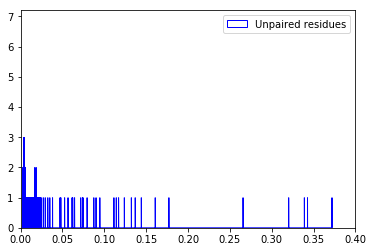

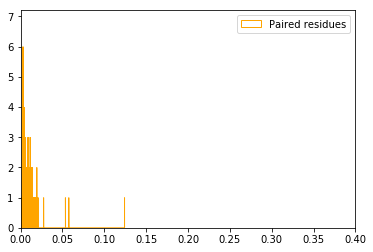

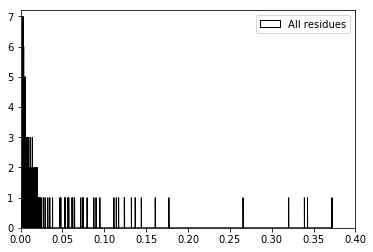

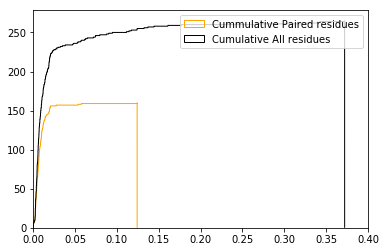

In [1]:
# SHAPE data for RNaseP
#
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from mpl_toolkits import mplot3d
from scipy.special import logsumexp
import time

shape_file_u = "data/RNASEP_DMS_0000.rdat.outu"
shape_file_p = "data/RNASEP_DMS_0000.rdat.outp"

datau = pd.read_csv(shape_file_u, sep=" ", header=None)[2]
datap = pd.read_csv(shape_file_p, sep=" ", header=None)[2]
datu  = datau.values.tolist()
datp  = datap.values.tolist()
dat   = datu+datp

Nu = len(datu)
Np = len(datp)
N  = len(dat)
print("Np ", Np, "Nu ", Nu, "N ", N)

# Student's T-test
ttest = stats.ttest_ind(datau,datap)
print("ttest ", ttest)

mean_u = np.mean(datau)
mean_p = np.mean(datap)
err2_u = (Nu-1)*np.var(datau)
err2_p = (Np-1)*np.var(datap)
denom  = np.sqrt((err2_u + err2_p)/(Nu+Np-2)) * np.sqrt(1/Nu + 1/Np)
ttest_val = abs(mean_u-mean_p) / denom
print("ttest val ", ttest_val)

# P(r|U) P(r|P)
nbin = 10000
datu_h = plt.hist(datu, color="b", histtype="step", bins=nbin, label='Unpaired residues')
plt.ylim(0,7.2)
plt.xlim(0,0.40)
plt.legend()
plt.show()

datp_h = plt.hist(datp, color="orange", histtype="step", bins=nbin, label='Paired residues')
plt.legend()
plt.ylim(0,7.2)
plt.xlim(0,0.40)
plt.show()

dat_h  = plt.hist(dat, color="black", histtype="step", bins=nbin, label='All residues')
plt.legend()
plt.ylim(0,7.2)
plt.xlim(0,0.40)
plt.show()

# the CDF for datau is the p-value
datu_cdf, datu_bins, datu_patches = plt.hist(datu, density = True, cumulative=True, histtype="step", bins=nbin, label=" P-values")
plt.legend()
plt.xlim(0,0.40)
plt.show()

pval = datu_cdf

# cumulative count of reactivities for pair/all residues
datp_ucdf, datp_bins, datp_patches = plt.hist(datp, color="orange",density = 0, cumulative=True, histtype="step", bins=nbin, label='Cummulative Paired residues')
dat_ucdf,  dat_bins,  dat_patches  = plt.hist(dat,  color="black", density = 0, cumulative=True, histtype="step", bins=nbin, label='Cumulative All residues')
plt.legend()
plt.xlim(0,0.40)
plt.show()



In [3]:
# Wednesday 30 Sep 2020
#
# P-value (r_target) = P(r < r_target | U)
#
nbin = 10000
pval, react, patches = plt.hist(datu, density = True, cumulative=True, bins=nbin, label=" P-values")

# Cumulative 
datp_cum, datp_bins, datp_patches = plt.hist(datp, density = 0, cumulative=True, bins=nbin, label='Cummulative Paired residues')
dat_cum,  dat_bins,  dat_patches  = plt.hist(dat,  density = 0, cumulative=True, bins=nbin, label='Cumulative All residues')

T = Np # T = The Trues (basepaired residues)

for i in range(nbin):
    
    # We use the P(r|U) as describing the null hypothesis
    pval_target = pval[i]
    r_target    = react[i]
    if r_target > 0.007:
        break
    
    #
    # r <= r_target are going to be assigned P
    # r >= r_target are going to be assigend U
    #
    
    # F = Found paired = total residues (out of N) with r <= r_target
    #
    for j in range(nbin):
        if dat_bins[j] <= r_target:
            F = dat_cum[j]      # F = Found
                
    # FP = expected false positives = expected from null to have r < r_target
    FP  = pval_target*N       # expected false positives
    FDR = FP/F                # False Discovery Rate = fraction of FP per found
        
    # TP = True positives = paired residues (out of Np) with r <= r_target
    #  we use TPs to calculate sensitivity
    #
    for j in range(nbin):
        if datp_bins[j] <= r_target:
             TP = datp_cum[j]    # TP = True Positives
        
    sen = TP/T * 100  # sensitivity = True basepairs found with  r < r_target
        
        
    # print all those numbers
    #
    #  T = 160 = # paired residues 
    #  N = 265 = # total residues
    #
    # r_target  pval_target F(found) [#P    #U]  sen(TP/T) exp_FP   FDR of F     pval of N          
        
    print("r_target", '{:.4f}'.format(r_target), "pval_target", '{:.4f}'.format(pval_target), "Found", 
          F, "[P", TP, "U", F-TP, "] sen", '{:.2f}'.format(sen), "exp FP", '{:.2f}'.format(FP), 
          "= FDR", '{:.4f}'.format(FDR), "of", F, "pval", '{:.4f}'.format(pval_target), "of", N)
        


r_target 0.0026 pval_target 0.0190 Found 25.0 [P 23.0 U 2.0 ] sen 14.37 exp FP 5.05 = FDR 0.2019 of 25.0 pval 0.0190 of 265
r_target 0.0026 pval_target 0.0190 Found 25.0 [P 23.0 U 2.0 ] sen 14.37 exp FP 5.05 = FDR 0.2019 of 25.0 pval 0.0190 of 265
r_target 0.0027 pval_target 0.0190 Found 25.0 [P 23.0 U 2.0 ] sen 14.37 exp FP 5.05 = FDR 0.2019 of 25.0 pval 0.0190 of 265
r_target 0.0027 pval_target 0.0190 Found 28.0 [P 26.0 U 2.0 ] sen 16.25 exp FP 5.05 = FDR 0.1803 of 28.0 pval 0.0190 of 265
r_target 0.0027 pval_target 0.0190 Found 28.0 [P 26.0 U 2.0 ] sen 16.25 exp FP 5.05 = FDR 0.1803 of 28.0 pval 0.0190 of 265
r_target 0.0028 pval_target 0.0190 Found 28.0 [P 26.0 U 2.0 ] sen 16.25 exp FP 5.05 = FDR 0.1803 of 28.0 pval 0.0190 of 265
r_target 0.0028 pval_target 0.0190 Found 29.0 [P 27.0 U 2.0 ] sen 16.88 exp FP 5.05 = FDR 0.1741 of 29.0 pval 0.0190 of 265
r_target 0.0029 pval_target 0.0190 Found 29.0 [P 27.0 U 2.0 ] sen 16.88 exp FP 5.05 = FDR 0.1741 of 29.0 pval 0.0190 of 265
r_target

In [ ]:
print(dat)

ev_H0 = 0
for x in range(len(dat)):
    r = dat[x]
    
    for j in 
        if r < datu_h_bins[j]:
            break
    ev_H0 += log(datu_h[j])
print(ev_H0)